# Summary

Cluster training data on most important features. Train a model on each cluster. During prediction, use the model of the cluster with the closest centroid.

## Insights

Todo

In [1]:
import re
import tempfile

import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sqlalchemy import create_engine

from JapanHorseRaceAnalytics.models.features_20240120_v1 import Features
from JapanHorseRaceAnalytics.utilities.base import get_data_dir, read_sql_table
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Load data

In [3]:
data = read_sql_table("features_20240120_v1", schema="jrdb_curated").astype(
    Features.get_pandas_dtypes()
)

# Only include races where トラック種別 is ダート or 芝
data = data[data["トラック種別"].isin(["ダート", "芝"])]

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240120_v1.snappy.parquet", "level": "info", "timestamp": "2024-01-31T22:27:49.462870Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


# Cluster based on important features

{"event": "Running kmeans with k=1", "level": "info", "timestamp": "2024-01-31T22:43:19.309392Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
/Users/hankehly/Projects/JapanHorseRaceAnalytics/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_4575/223805204.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["clusters"] = kmeans.labels_
{"event": "Running kmeans with k=2", "level": "info", "timestamp": "2024-01-31T22:43:21.108229Z", "logger": "JapanHorseRaceAnalytics.utiliti

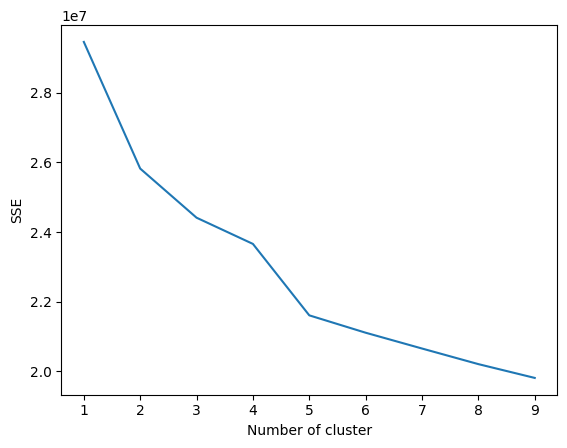

In [11]:
important_features = [
    "トラック種別",
    "入厩何日前",
    "temperature",
    "馬体重",
    "中間降水量",
    "騎手1位完走平均賞金",
    "展開予想データ_テン指数",
    "wind_speed",
    "展開予想データ_位置指数",
    "local_air_pressure",
    "万券指数",
    "調教指数",
    "調教師1位完走平均賞金",
    "馬場差",
    "relative_humidity",
    "展開予想データ_上がり指数",
    "厩舎指数",
    "激走指数",
    "調教師場所1位完走率",
    "展開予想データ_ペース指数",
    "solar_radiation",
    "IDM標準偏差",
    "単勝オッズ",
    "複勝オッズ",
    "年齢",
    "人気指数",
    "展開予想データ_ゴール差",
    "基準複勝オッズ",
]

X_clustering = data[important_features]
numeric_features = X_clustering.select_dtypes("number").columns.tolist()
categorical_features = X_clustering.select_dtypes("category").columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("std_scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            categorical_features,
        ),
    ]
)
X_clustering_prep = preprocessor.fit_transform(X_clustering)
sse = {}
for k in range(1, 10):
    logger.info(f"Running kmeans with k={k}")
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_clustering_prep)
    data["clusters"] = kmeans.labels_
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# Train/test split

In [4]:
X = data.drop(Features.get_label(), axis="columns")
y = data[Features.get_label()]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (857061, 288)
X_test: (214266, 288)
y_train: (857061,)
y_test: (214266,)
